In [4]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats
import cmocean

from plotting import plot_utils, summary_plots, load_fits
from utils import roi_utils, default_paths, prf_utils
from feature_extraction import gabor_feature_extractor
import copy

#### Load fit results

In [46]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'gabor_solo_ridge_12ori_8sf'
out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, \
                                  verbose=False) for ss in subjects]

# create non-overlapping ROIs
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

# make a list of voxels per subject
n_vox_each_subj = [out[si]['best_params'][0].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones((n_vox_each_subj[si],),dtype=int) \
                               for si in range(n_subjects)], axis=0)

# thresholding voxels based on their R2 for this model
r2_cutoff = 0.01
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff

In [60]:
name = 'semantic_discrim_raw_val_all'

which_axes_negate = [1]
signed_names = ['outdoor > indoor', 'animate > inanimate', 'large > small']

sem_group_names = ['outdoor','indoor','animate','inanimate','large','small']
n_sem_groups = len(sem_group_names)

p_thresh = 0.01
n_dims = len(signed_names)

sem_tvals = [[] for ss in subjects]
sem_pvals = [[] for ss in subjects]
sem_groups = [[] for ss in subjects]

for si, ss in enumerate(subjects):
    
    # load the semantic selectivity results for each voxel
    out_sem = load_fits.load_fit_results(ss, name, n_from_end=0,verbose=False);
    assert(out_sem['average_image_reps']==True)
    
    t = copy.deepcopy(out_sem['sem_discrim_each_axis'])[:,out_sem['axes_to_do']]
    t[:,which_axes_negate] *= (-1)
    sem_tvals[si] = t
    
    # compute the p-value for each t-statistic, based on the degrees of freedom
    # (number of samples)
    nsamp = out_sem['n_sem_samp_each_axis'][:,out_sem['axes_to_do'],:]
    df = nsamp[:,:,0]+nsamp[:,:,1]-2
    # two-tailed test, multiply by 2
    p = scipy.stats.t.sf(np.abs(t), df)*2

    sem_pvals[si] = p;   
    
    n_vox = p.shape[0]
    sem_groups[si] = np.zeros((n_vox, n_dims*2))
    
    gg=-1
    for dim in range(n_dims):
        
        gg+=1
        sem_groups[si][:,gg] = (p[:,dim]<p_thresh) & (t[:,dim]>0)
        gg+=1
        sem_groups[si][:,gg] = (p[:,dim]<p_thresh) & (t[:,dim]<0)
            

In [61]:
[np.sum(sem_groups[si], axis=0) for si in range(n_subjects)]

[array([2657., 4952., 3013., 5560., 1372., 2574.]),
 array([2234., 6828., 3007., 6810.,  788., 4137.]),
 array([1316., 6471., 2821., 5250.,  360., 3049.]),
 array([2342., 4526., 3174., 4729.,  306., 2011.]),
 array([2831., 7126., 3637., 6856., 1030., 3372.]),
 array([3567., 3929., 4175., 4492.,  649., 3091.]),
 array([1995., 4407., 2373., 4437.,  735., 1881.]),
 array([1316., 3542., 1651., 3639.,  139., 1421.])]

#### Get info about_sem the Gabor feature space

In [62]:
n_sf=8; n_ori=12;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)


#### Organize the feature sensitivity matrices
feature sensitivity = corr coef between model resp and feature channel activation

In [63]:
feature_corr = np.concatenate([out[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

# find maxes for orient/SF
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_orient_corr[:,0:1], [1,n_ori])==mean_orient_corr, axis=1)
assert(not(np.any(is_constant)))

preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_corr[:,0:1], [1,n_sf])==mean_sf_corr, axis=1)
assert(not(np.any(is_constant)))


In [109]:
# feature_corr_maxes = copy.deepcopy(feature_corr)
max_inds = np.argmax(feature_corr, axis=1)
feature_prefs = np.concatenate([np.arange(n_ori*n_sf)[None,:]==mm for mm in max_inds], axis=0).astype(int)
feature_prefs_reshaped = np.reshape(feature_prefs, [n_voxels, n_ori, n_sf], order='F')

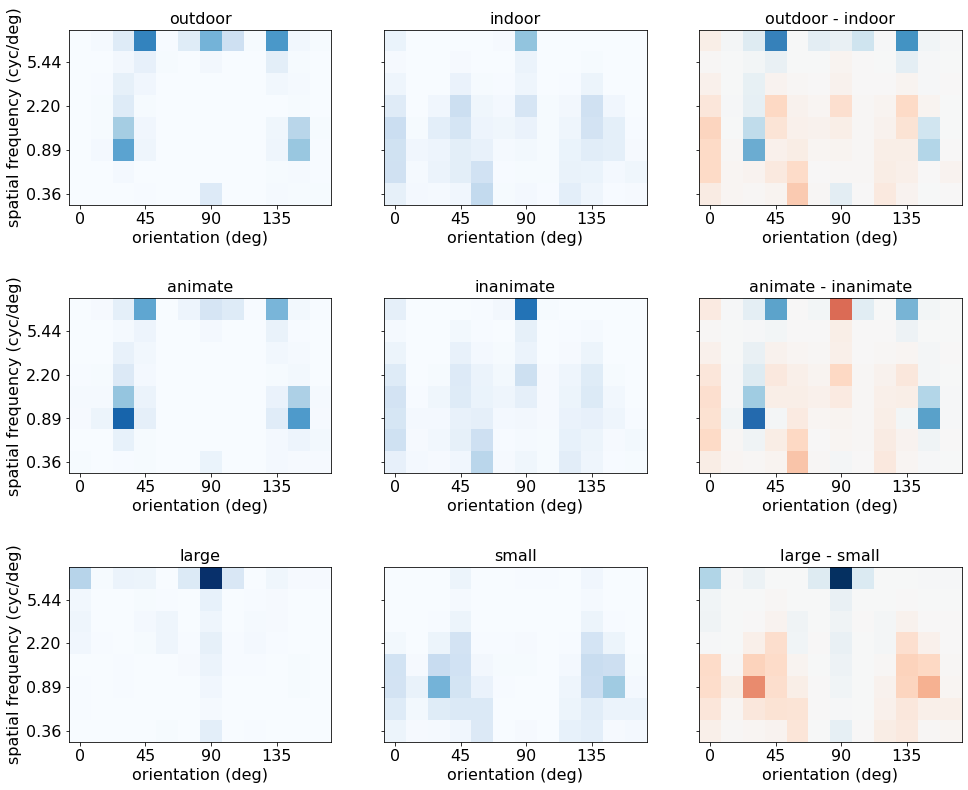

In [138]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(16,14))

pi=0

clims = [0, 0.20]

pairs = [[0,1],[2,3],[4,5]]

for pair in pairs:
    
    rr = pair[0]
    inds_this_roi = (np.concatenate([sem_groups[si][:,rr] \
                            for si in range(n_subjects)], axis=0)==1)
    inds_this_roi = inds_this_roi & abv_thresh 

    vals1 = np.mean(feature_prefs_reshaped[inds_this_roi,:,:], axis=0)

    rr = pair[1]
    inds_this_roi = (np.concatenate([sem_groups[si][:,rr] \
                            for si in range(n_subjects)], axis=0)==1)
    inds_this_roi = inds_this_roi & abv_thresh 

    vals2 = np.mean(feature_prefs_reshaped[inds_this_roi,:,:], axis=0)

    for xx in [0,1,2]:
        
        pi+=1
        plt.subplot(3,3,pi)

        if xx==0:
            vals = vals1;
            name = sem_group_names[pair[0]]
            plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.Blues)

        elif xx==1:
            vals = vals2;
            name = sem_group_names[pair[1]]
            plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.Blues)

        else:
            vals = vals1 - vals2;
            name = '%s - %s'%(sem_group_names[pair[0]],sem_group_names[pair[1]])
            plt.pcolormesh(vals.T,  vmin=-0.2, vmax=0.2, cmap=cm.RdBu)

        plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
        sf_ticks = sf_unique[[0,2,4,6]].round(2)
        if xx==0:
            plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
            plt.ylabel('spatial frequency (cyc/deg)')
        else:
            plt.yticks(np.array([0,2,4,6])+0.5,[])
        plt.axis('square')
        plt.xlim([0,12])
        plt.ylim([0,8])

        plt.xlabel('orientation (deg)')
        plt.title(name)


In [120]:
np.min(vals)

0.0

#### Plot distribution of preferred orientation
Merge voxels over all participants

Text(0.5, 0.98, 'Distribution of preferred orientation (max sensitivity), all voxels across 8 subjects')

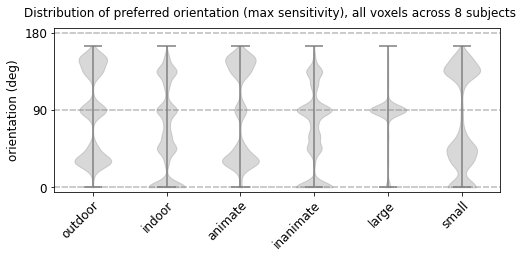

In [64]:
plot_utils.set_all_font_sizes(12)

plt.rcParams['pdf.fonttype']=42

color = '#7f7f7f'
    
plt.figure(figsize=(8,3))

for gg in range(n_sem_groups):
# for ri in range(n_rois):

    
    inds_this_roi = (np.concatenate([sem_groups[si][:,gg] \
                                    for si in range(n_subjects)], axis=0)==1) \
                                    & abv_thresh
    
    parts = plt.violinplot(ori_unique[preferred_ori_corr[inds_this_roi].astype(int)],[gg])
    for pc in parts['bodies']:
        pc.set_color(color)
    parts['cbars'].set_color(color)
    parts['cmins'].set_color(color)
    parts['cmaxes'].set_color(color)

    plt.yticks([0,90,180])
    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    plt.axhline(90,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    plt.axhline(180,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    
    plt.ylabel('orientation (deg)')
    plt.ylim([-5, 185])
    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

plt.xticks(ticks=np.arange(0,n_sem_groups),labels=sem_group_names,\
                       rotation=45, ha='right',rotation_mode='anchor')

plt.suptitle('Distribution of preferred orientation (max sensitivity), all voxels across 8 subjects')

# fn2save = os.path.join(default_paths.fig_path,'Gabor_orient_violin.pdf')
# plt.savefig(fn2save)

#### Plot distribution of preferred spatial frequency

Text(0.5, 0.98, 'Distribution of preferred spatial frequency (max sensitivity), all voxels across 8 subjects')

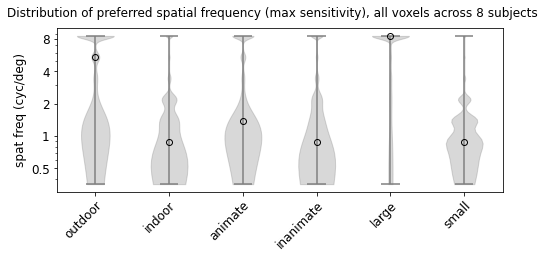

In [67]:

plot_utils.set_all_font_sizes(12)

plt.rcParams['pdf.fonttype']=42

color = '#7f7f7f'

plt.figure(figsize=(8,3))

for gg in range(n_sem_groups):
# for ri in range(n_rois):

    
    inds_this_roi = (np.concatenate([sem_groups[si][:,gg] \
                                    for si in range(n_subjects)], axis=0)==1) \
                                    & abv_thresh
     
    parts = plt.violinplot(sf_unique[preferred_sf_corr[inds_this_roi].astype(int)],[gg])
    for pc in parts['bodies']:
        pc.set_color(color)
    parts['cbars'].set_color(color)
    parts['cmins'].set_color(color)
    parts['cmaxes'].set_color(color)
    
    plt.plot(gg, np.median(sf_unique[preferred_sf_corr[inds_this_roi].astype(int)]),\
             marker='o',color='k', markerfacecolor='none')

    # plt.yticks([0,4,8])
    plt.gca().set_yscale('log')
    plt.yticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [0.5,1,2,4,8])
   
    plt.ylabel('spat freq (cyc/deg)')

    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

plt.xticks(ticks=np.arange(0,n_sem_groups),labels=sem_group_names,\
                       rotation=45, ha='right',rotation_mode='anchor');

plt.suptitle('Distribution of preferred spatial frequency (max sensitivity), all voxels across 8 subjects')

# fn2save = os.path.join(default_paths.fig_path,'Gabor_spatfreq_violin.pdf')
# plt.savefig(fn2save)

#### Now compute ROI-averaged response profiles
For each participant separately

In [71]:
avg_resp_profiles = np.zeros((n_subjects, n_sem_groups, n_ori, n_sf))
for si in range(n_subjects):
    for gg in range(n_sem_groups):
    # for ri in range(n_rois):

        inds_this_roi = (np.concatenate([sem_groups[si][:,gg] \
                                    for si in range(n_subjects)], axis=0)==1)
        inds_this_roi = inds_this_roi & abv_thresh & (subject_inds==si)   
        avg_resp_profiles[si,gg,:,:] = np.mean(allcorr_reshaped[inds_this_roi,:,:], axis=0)

In [73]:
n_rois = n_sem_groups
roi_names = sem_group_names

#### Plot average orientation sensitivity profiles for each ROI

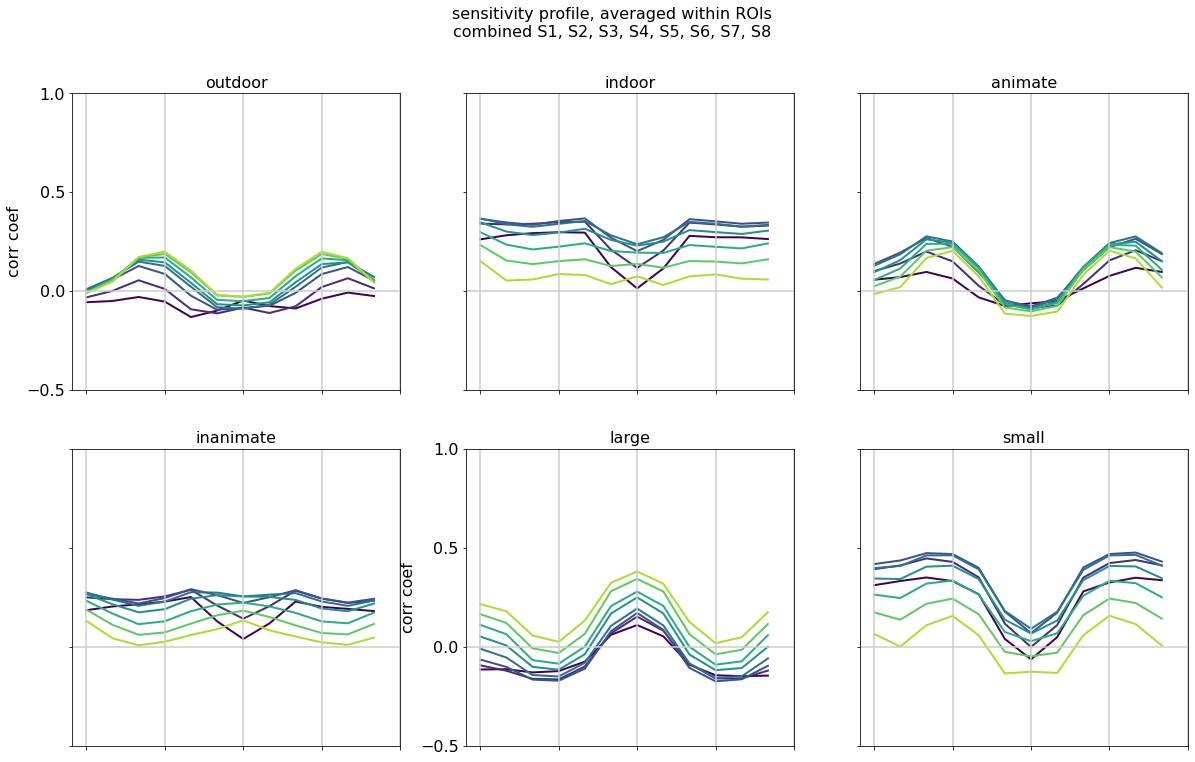

In [90]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_sem_groups)))
npx = int(np.ceil((n_sem_groups)/npy))

colors = cm.viridis(np.linspace(0,1,n_sf+1))[0:-1,:]

pi=0

for rr in range(n_sem_groups):
    
    pi+=1
    plt.subplot(npx,npy,pi)

    vals = np.mean(avg_resp_profiles[:,rr,:,:], axis=2)
    meanvals = np.mean(vals , axis=0)
   
    for sf in range(n_sf):
        vals = avg_resp_profiles[:,rr,:,sf]
        meanvals = np.mean(vals , axis=0)
       
        plt.plot(ori_unique,  meanvals, '-',color=colors[sf,:],linewidth=2)

    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.5,1])
    
    if np.mod(rr,4)==0:
        plt.ylabel('corr coef')
        plt.yticks(np.arange(-0.5, 1.2, 0.5))

    else:
        plt.yticks(np.arange(-0.5, 1.2, 0.5), labels=[])

    if pi>8:
        plt.xlabel('orientation (deg)')
        plt.xticks(np.arange(0,181,45))
    else:
        plt.xticks(np.arange(0,181,45), labels=[])

    for ii in np.arange(0,181,45):
        plt.axvline(ii,color=[0.8, 0.8, 0.8])

    plt.title('%s'%(sem_group_names[rr]))

plt.suptitle('sensitivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out))

fn2save = os.path.join(default_paths.fig_path, 'Orient_sensitivity_allareas.pdf')
plt.savefig(fn2save)

Text(0.5, 0.98, 'sensitivity profile, averaged within ROIs\ncombined S1, S2, S3, S4, S5, S6, S7, S8')

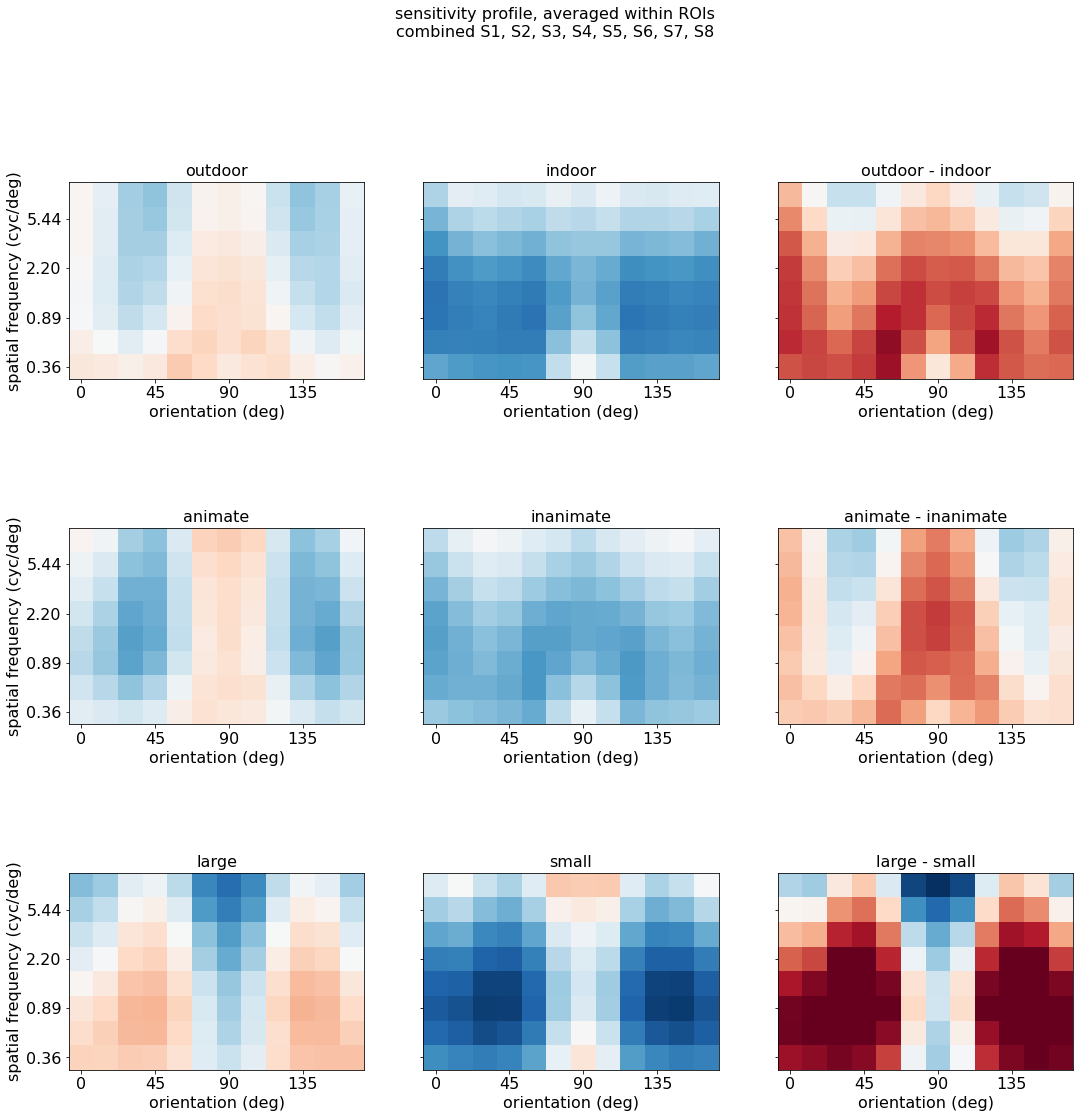

In [96]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(18,18))
# npy = int(np.ceil(np.sqrt(n_sem_groups)))
# npx = int(np.ceil((n_sem_groups)/npy))

pi=0

clims = [-0.5, 0.5]

pairs = [[0,1],[2,3],[4,5]]

for pair in pairs:

    for xx in [0,1,2]:
        
        pi+=1
        plt.subplot(3,3,pi)

        if xx<2:
            vals = np.mean(avg_resp_profiles[:,pair[xx],:,:], axis=0)
            name = sem_group_names[pair[xx]]
        else:
            vals = np.mean(avg_resp_profiles[:,pair[0],:,:] - avg_resp_profiles[:,pair[1],:,:], axis=0)
            name = '%s - %s'%(sem_group_names[pair[0]], sem_group_names[pair[1]])
            
        plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.RdBu)

        plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
        sf_ticks = sf_unique[[0,2,4,6]].round(2)
        if xx==0:
            plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
            plt.ylabel('spatial frequency (cyc/deg)')
        else:
            plt.yticks(np.array([0,2,4,6])+0.5,[])
        plt.axis('square')
        plt.xlim([0,12])
        plt.ylim([0,8])
        # plt.axis('off')

        plt.xlabel('orientation (deg)')
        # else:
        #     plt.yticks(np.array([0,2,4,6])+0.5, [])

        plt.title(name)

plt.suptitle('sensitivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out))

# fn2save = os.path.join(default_paths.fig_path, 'Orient_sensitivity_allareas.pdf')
# plt.savefig(fn2save)

#### Plot average spatial frequency sensitivity profiles for each ROI

Text(0.5, 0.98, 'sensitivity profile, averaged within ROIs\ncombined S1, S2, S3, S4, S5, S6, S7, S8')

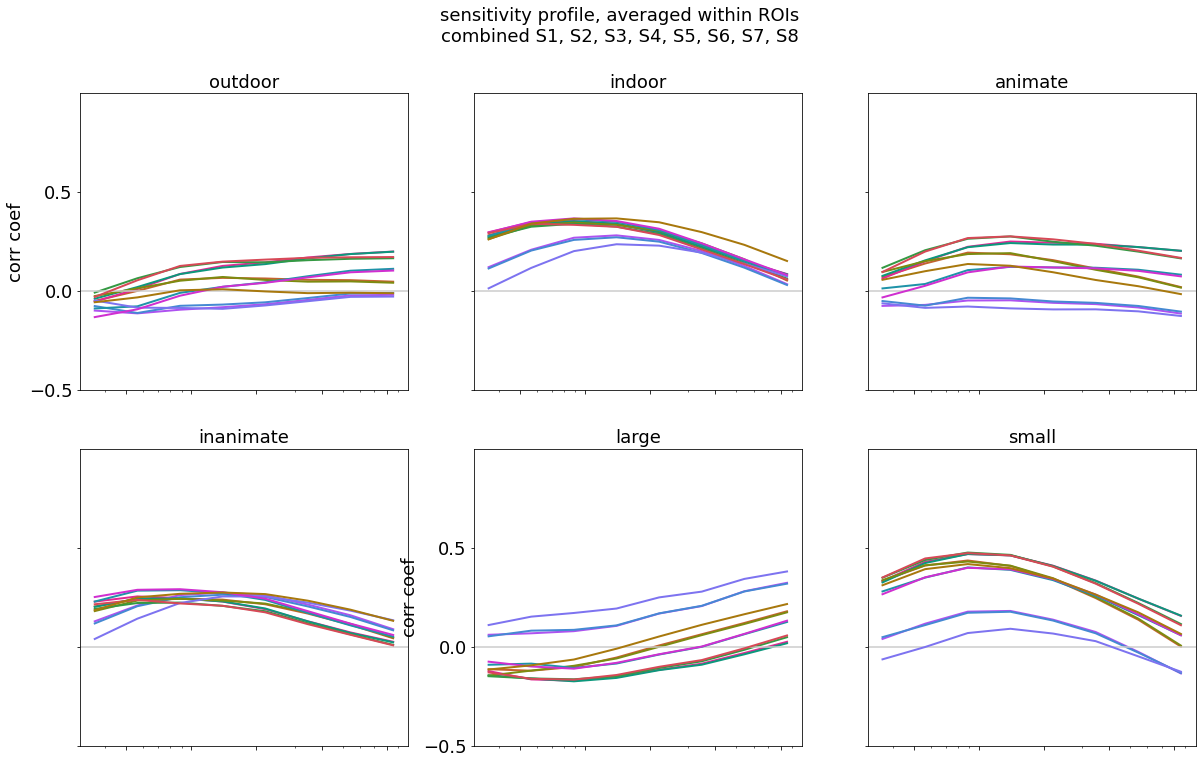

In [98]:
plot_utils.set_all_font_sizes(fs = 18)

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_sem_groups)))
npx = int(np.ceil((n_sem_groups)/npy))

colors = cmocean.cm.phase(np.linspace(0,1,n_ori+1))[0:-1,:]
# choose the order in which to layer the lines...some of them overlap almost completely, 
# so this makes it a little easier to see colors
zorders = np.arange(n_ori, 0, -1)
zorders[np.arange(1,12,2)]*=(-1)


pi=0
for rr in range(n_sem_groups):
    
    vals = np.mean(avg_resp_profiles[:,rr,:,:], axis=1)
    meanvals = np.mean(vals , axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)
    
    pi+=1
    plt.subplot(npx,npy,pi)

    for oo in range(n_ori):
        vals = avg_resp_profiles[:,rr,oo,:]
        meanvals = np.mean(vals , axis=0)

        plt.plot(sf_unique,  meanvals, '-',color=colors[oo,:],linewidth=2, zorder=zorders[oo])
        
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.5,1])

    if np.mod(pi,4)==1:
        plt.ylabel('corr coef')
        plt.yticks(np.arange(-0.5, 1, 0.5))
    else:
        plt.yticks(np.arange(-0.5, 1, 0.5), [])
    plt.gca().set_xscale('log')
    if pi>8:
        plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [0.5,1,2,4,8])
        plt.xlabel('spat freq (cyc/deg)')
    else:
        plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [])

    plt.title('%s'%(sem_group_names[rr]))

plt.suptitle('sensitivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out))

# fn2save = os.path.join(default_paths.fig_path, 'Freq_sensitivity_allareas.pdf')
# plt.savefig(fn2save)


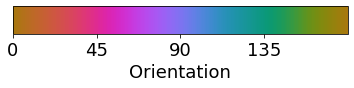

In [10]:
# make colorbar for orientation color coding
import matplotlib

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = cmocean.cm.phase
norm = matplotlib.colors.Normalize(vmin=0, vmax=180)

cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', \
                                ticks=[0, 45, 90, 135])
cb1.set_label('Orientation')
fig.show()

fn2save = os.path.join(default_paths.fig_path, 'Orient_colorbar.pdf')
plt.savefig(fn2save)